# Multiple output from LSTM model

## Operator 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

### Processing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

### LSTM functions

In [4]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_pred': train_pred,
               'train_true': y_train,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results


'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_in:int, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_in} steps in, {n_steps_out} steps out\n{operator}', fontsize=16, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return fig, means

### Overlapping campaigns

- Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight, Ping_8888_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight, Capacity_Ookla_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia__Test_2_No_Flight_Mode

- Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode, Capacity_Ookla_4G5G_Vodafone_Driving_Viale_Marconi, (Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode)

- Ping_UNIDATA_4G5G_Vodafone_Walking_Fornetto_Durant_Gianicolense, Ping_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense_No_Flight, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense, (Ping_UNIDATA_4G5G_Vodafone_Driving_Vatican_Area_to_Sabino_Route_2_No_Flight_Mode), (Ping_8888_4G5G_Vodafone_Walkong_Sabino_to_Stat_Trastevere, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Sabino_to_Stat_Trastevere_Test_2)

- Ping_UNIDATA_4G5G_Vodafone_Driving_Luca, Interactivity_gaming_4G5G_Vodafone_Driving_Luca, Capacity_Ookla_4G5G_Vodafone_Driving_Luca

### Parameters

In [5]:
tf.random.set_seed(4567)

In [6]:
overlap_1 = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
             'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Viale_Marconi', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight', 
             'Ping_8888_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia__Test_2_No_Flight_Mode']

overlap_3 = ['Ping_UNIDATA_4G5G_Vodafone_Walking_Fornetto_Durant_Gianicolense', 
             'Ping_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense_No_Flight', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense', 
             'Ping_UNIDATA_4G5G_Vodafone_Driving_Vatican_Area_to_Sabino_Route_2_No_Flight_Mode', 
             'Ping_8888_4G5G_Vodafone_Walkong_Sabino_to_Stat_Trastevere', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Sabino_to_Stat_Trastevere_Test_2']

overlap_4 = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Luca', 
             'Interactivity_gaming_4G5G_Vodafone_Driving_Luca', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Luca']

In [7]:
train = read_dataset('datasets/Op2_merged.csv', campaigns=[overlap_1[1]])
test = read_dataset('datasets/Op2_merged.csv', campaigns=[overlap_1[0]])
operator = 'Operator 2'

In [8]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                    #  ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                    #  ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ']]#, 
                    #  ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

## Testing n units for m layers

In [9]:
# parameters
n_steps_in = 2
n_steps_out = 5
units = [[5, 5], [5, 10], [10, 10], [5, 5, 5], [5, 5, 10], [5, 10, 5], [10, 5, 5], [5, 10, 10], [10, 5, 10], [10, 10, 5], [10, 10, 10], [10, 20, 10], [5, 5, 5, 5], [10, 10, 10, 10]]
features = ['RSRP', 'SSS_RSRP']
 
results = {}

for unit in units:
    layers = ' ->'.join(map(str, unit))
    warnings.simplefilter(action='ignore')
    features.extend(['campaign'])
    results[layers] = long_short_term_memory(train=train[features], test=test[features], target_feature='RSRP', features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=unit)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,5 ->5,0.01791,0.00509,2.80,1.71
1,5 ->10,0.00985,0.00612,1.93,1.54
2,10 ->10,0.00938,0.00581,1.86,1.46
3,5 ->5 ->5,0.01832,0.01725,4.32,3.55
4,5 ->5 ->10,0.01324,0.01040,2.37,2.06
5,5 ->10 ->5,0.01317,0.00531,1.90,1.43
6,10 ->5 ->5,0.01306,0.00482,1.74,1.27
7,5 ->10 ->10,0.01469,0.00942,3.36,2.55
8,10 ->5 ->10,0.01123,0.00609,1.99,1.52
9,10 ->10 ->5,0.01237,0.00691,1.93,1.53


## 2 Steps prediction

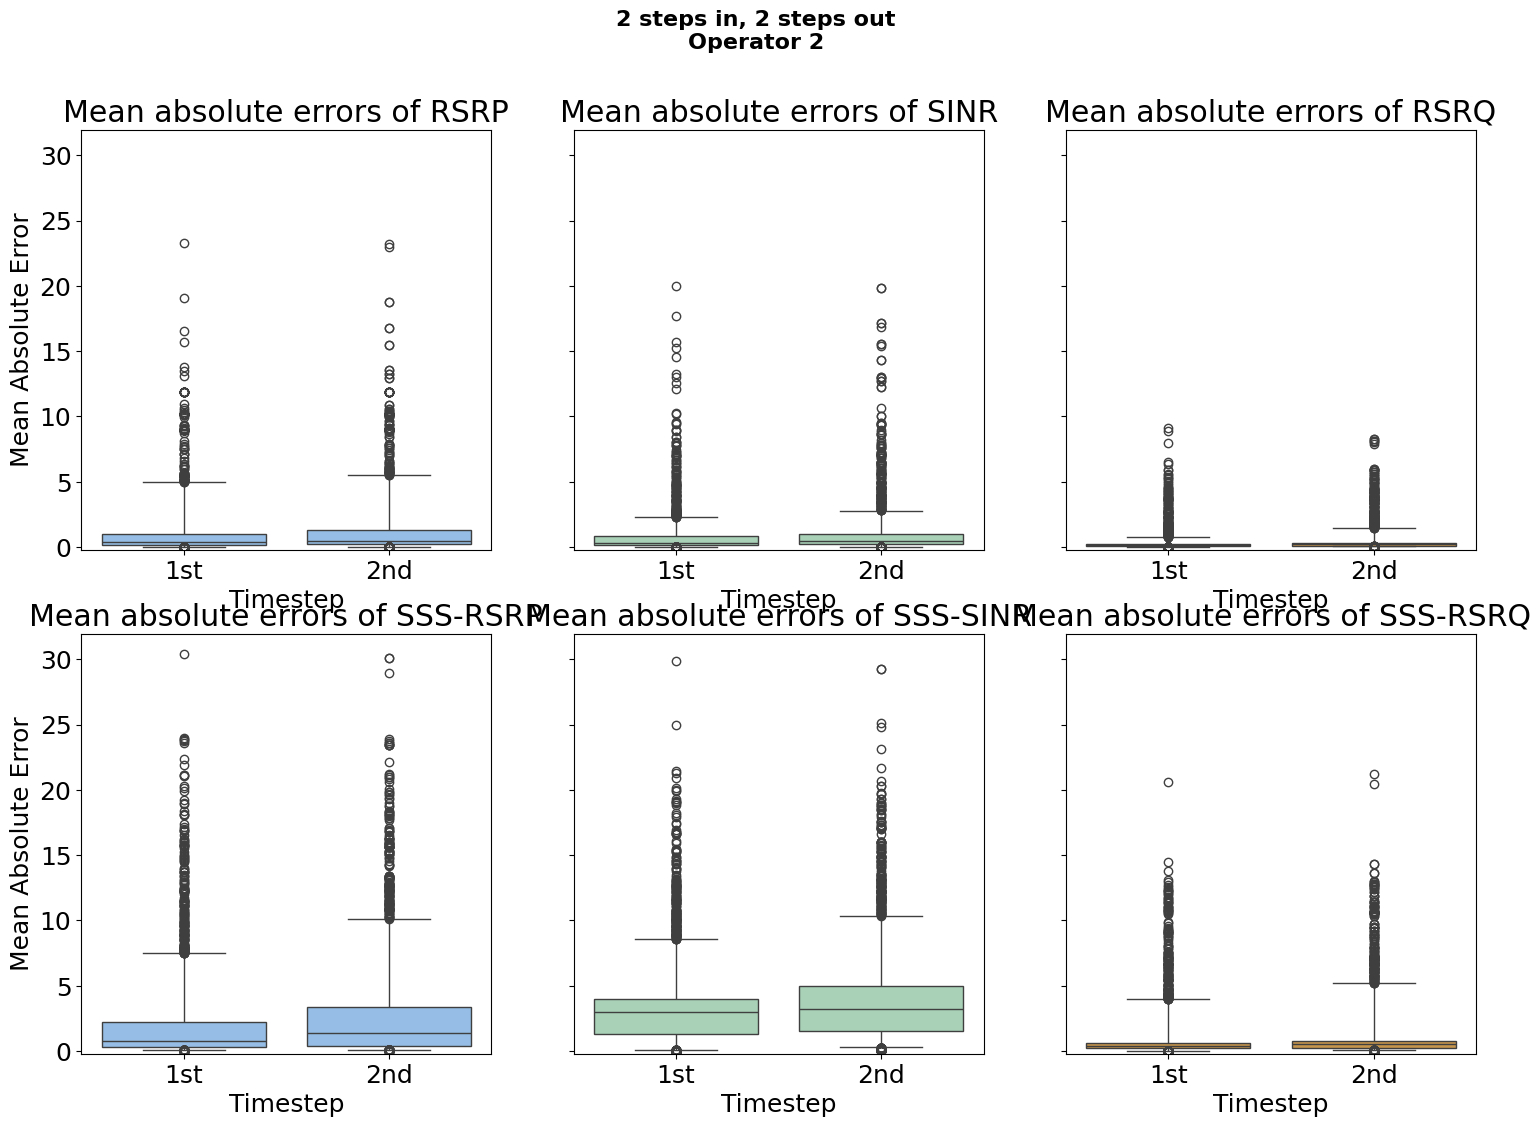

In [44]:
units = [10, 10]
n_steps_in = 2
n_steps_out = 2

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_2_steps_mae.pdf')

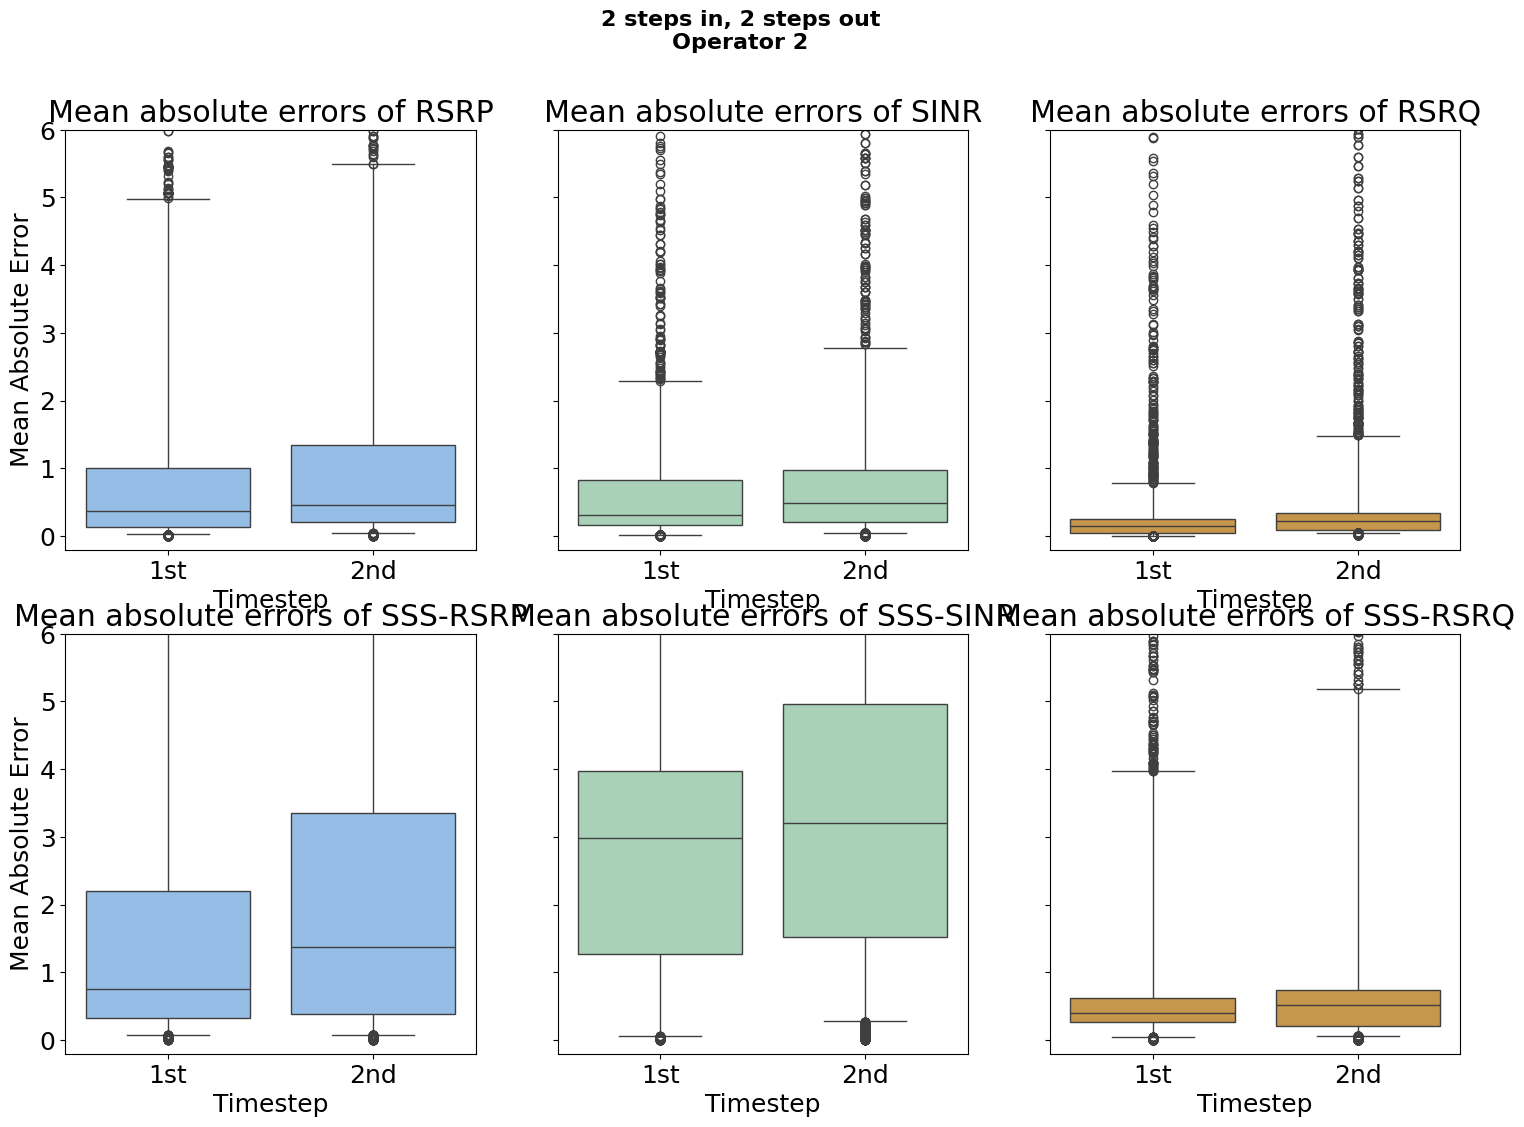

In [45]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator, y_lim=6)
fig.savefig(r'../latex/plots/lstm/op2_box_2_steps_mae_zoom.pdf')

In [46]:
mae_each_step

,1st,2nd
RSRP,1.133,1.339
SINR,0.647,0.864
RSRQ,0.271,0.421
SSS-RSRP,1.930,2.652
SSS-SINR,3.247,3.879
SSS-RSRQ,0.893,1.115


## 3 Steps Prediction

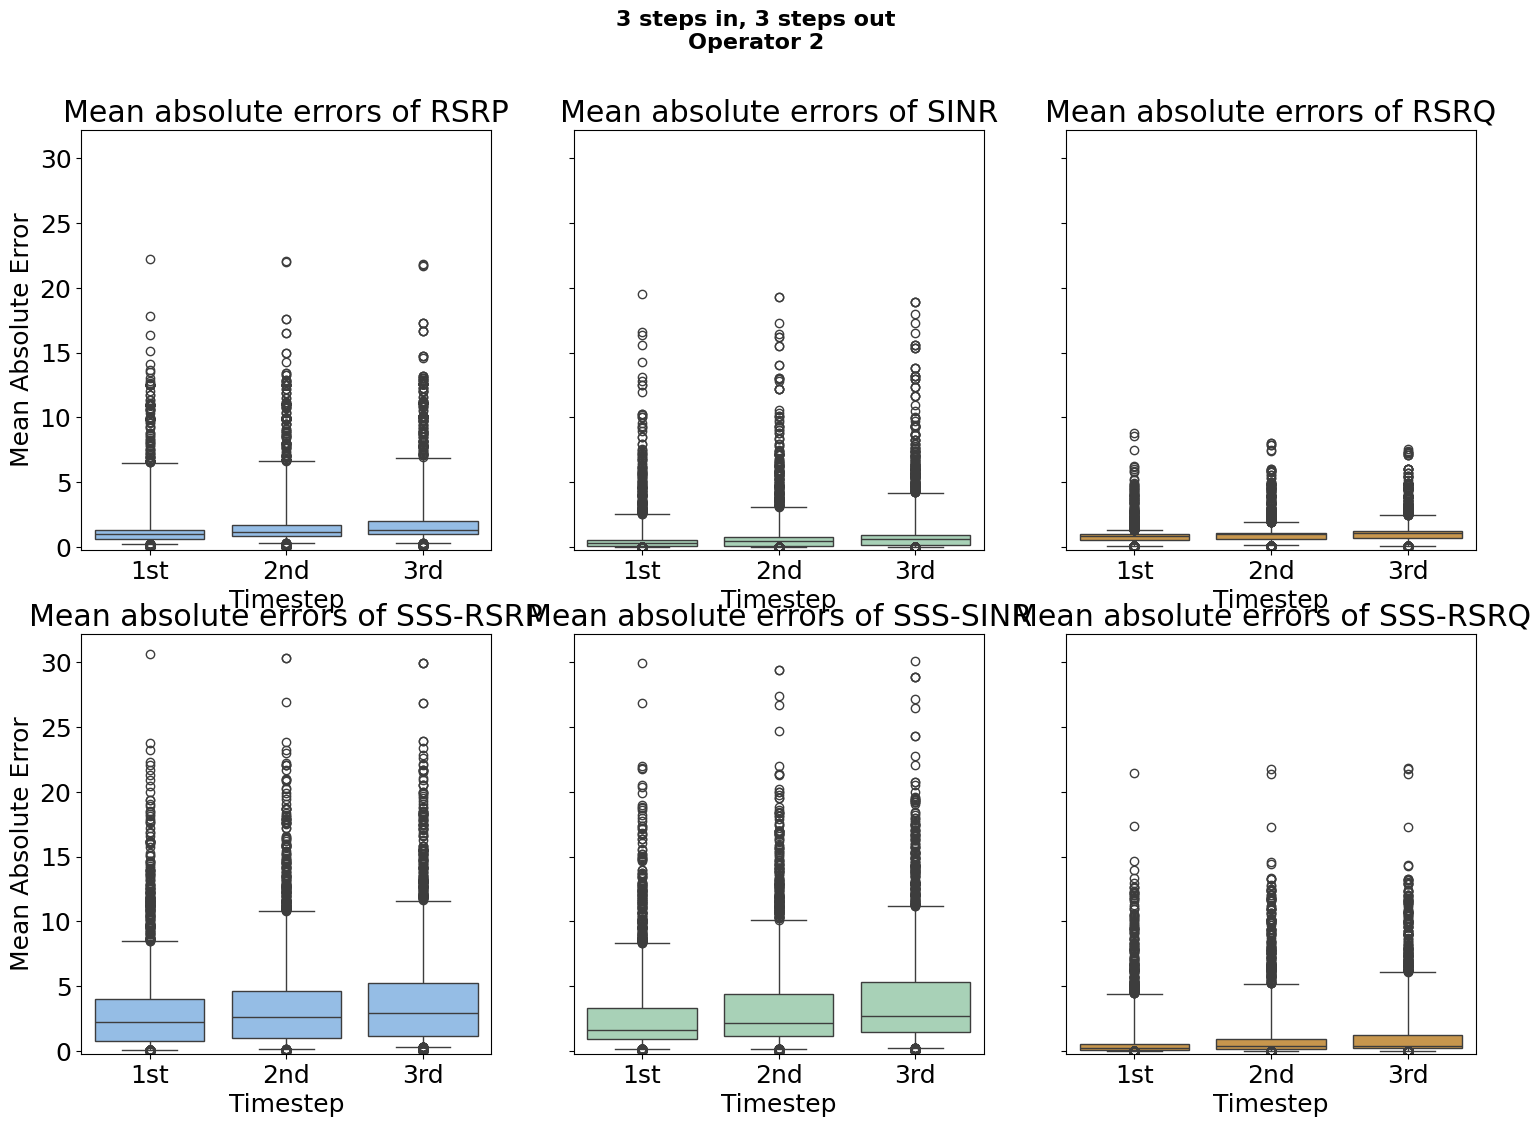

In [47]:
n_steps_in = 3
n_steps_out = 3

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_3_steps_mae.pdf')

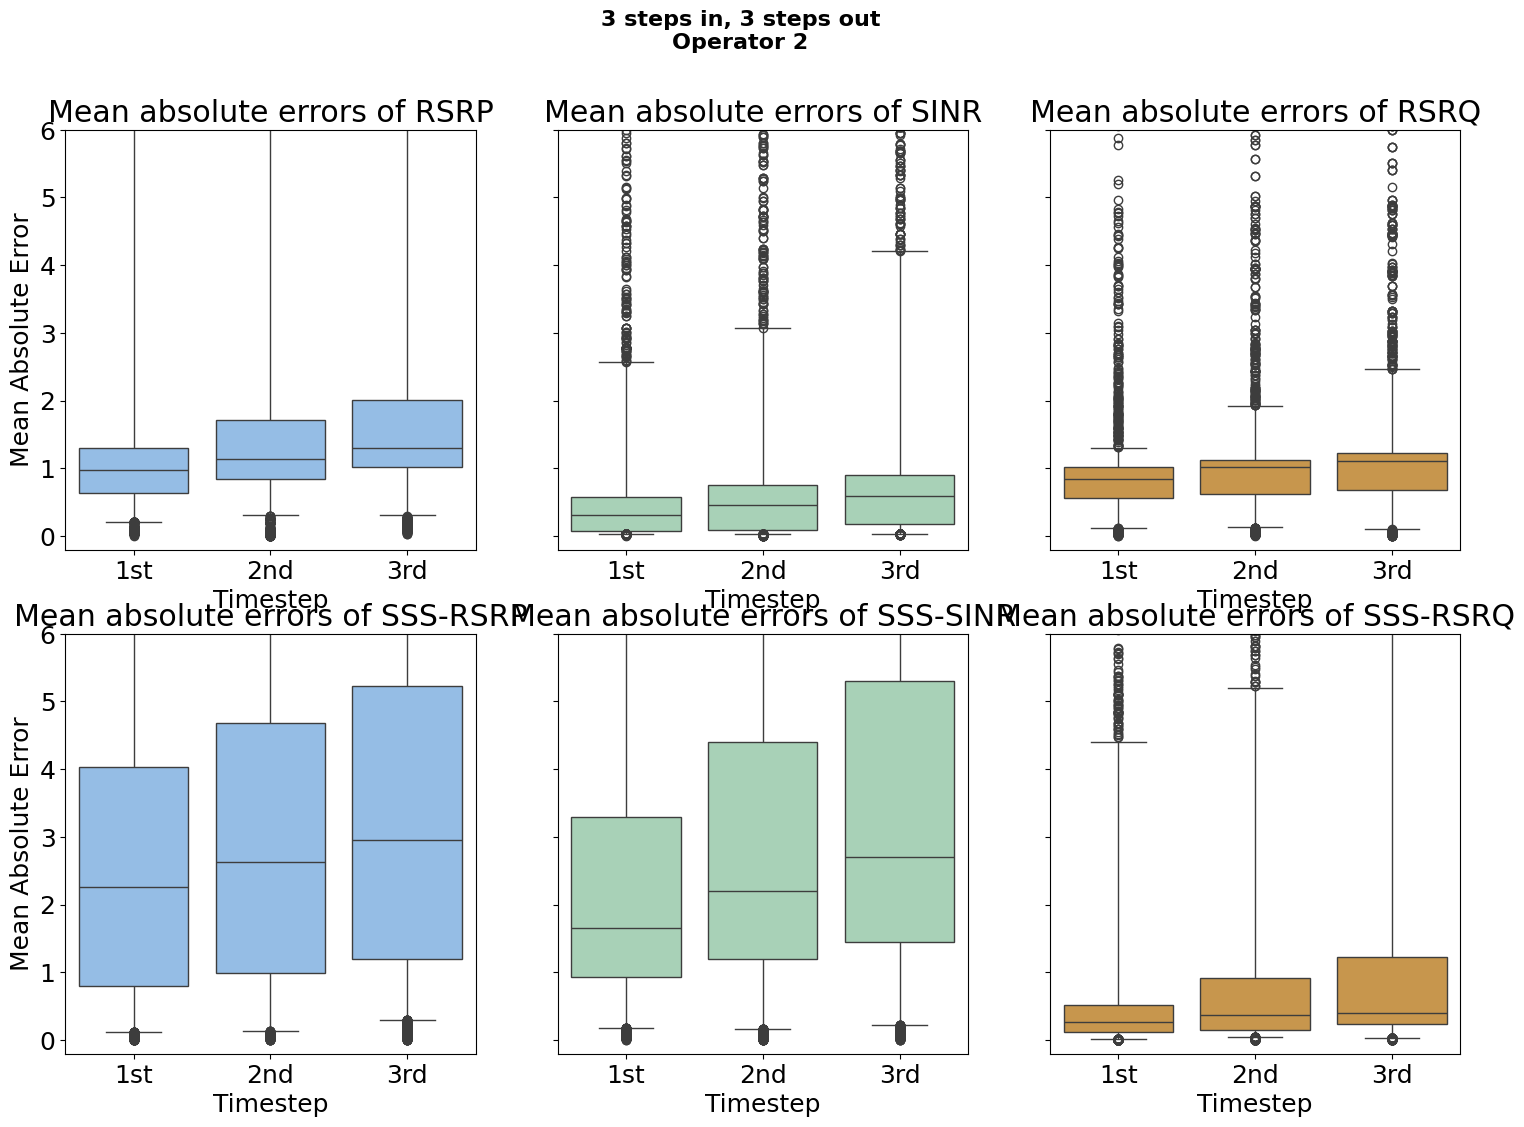

In [48]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator, y_lim=6)
fig.savefig(r'../latex/plots/lstm/op2_box_3_steps_mae_zoom.pdf')

In [49]:
mae_each_step

,1st,2nd,3rd
RSRP,1.717,1.942,2.179
SINR,0.622,0.826,1.043
RSRQ,0.831,0.963,1.095
SSS-RSRP,2.981,3.489,3.919
SSS-SINR,2.655,3.334,3.878
SSS-RSRQ,0.860,1.093,1.285


## 5 Steps Prediction

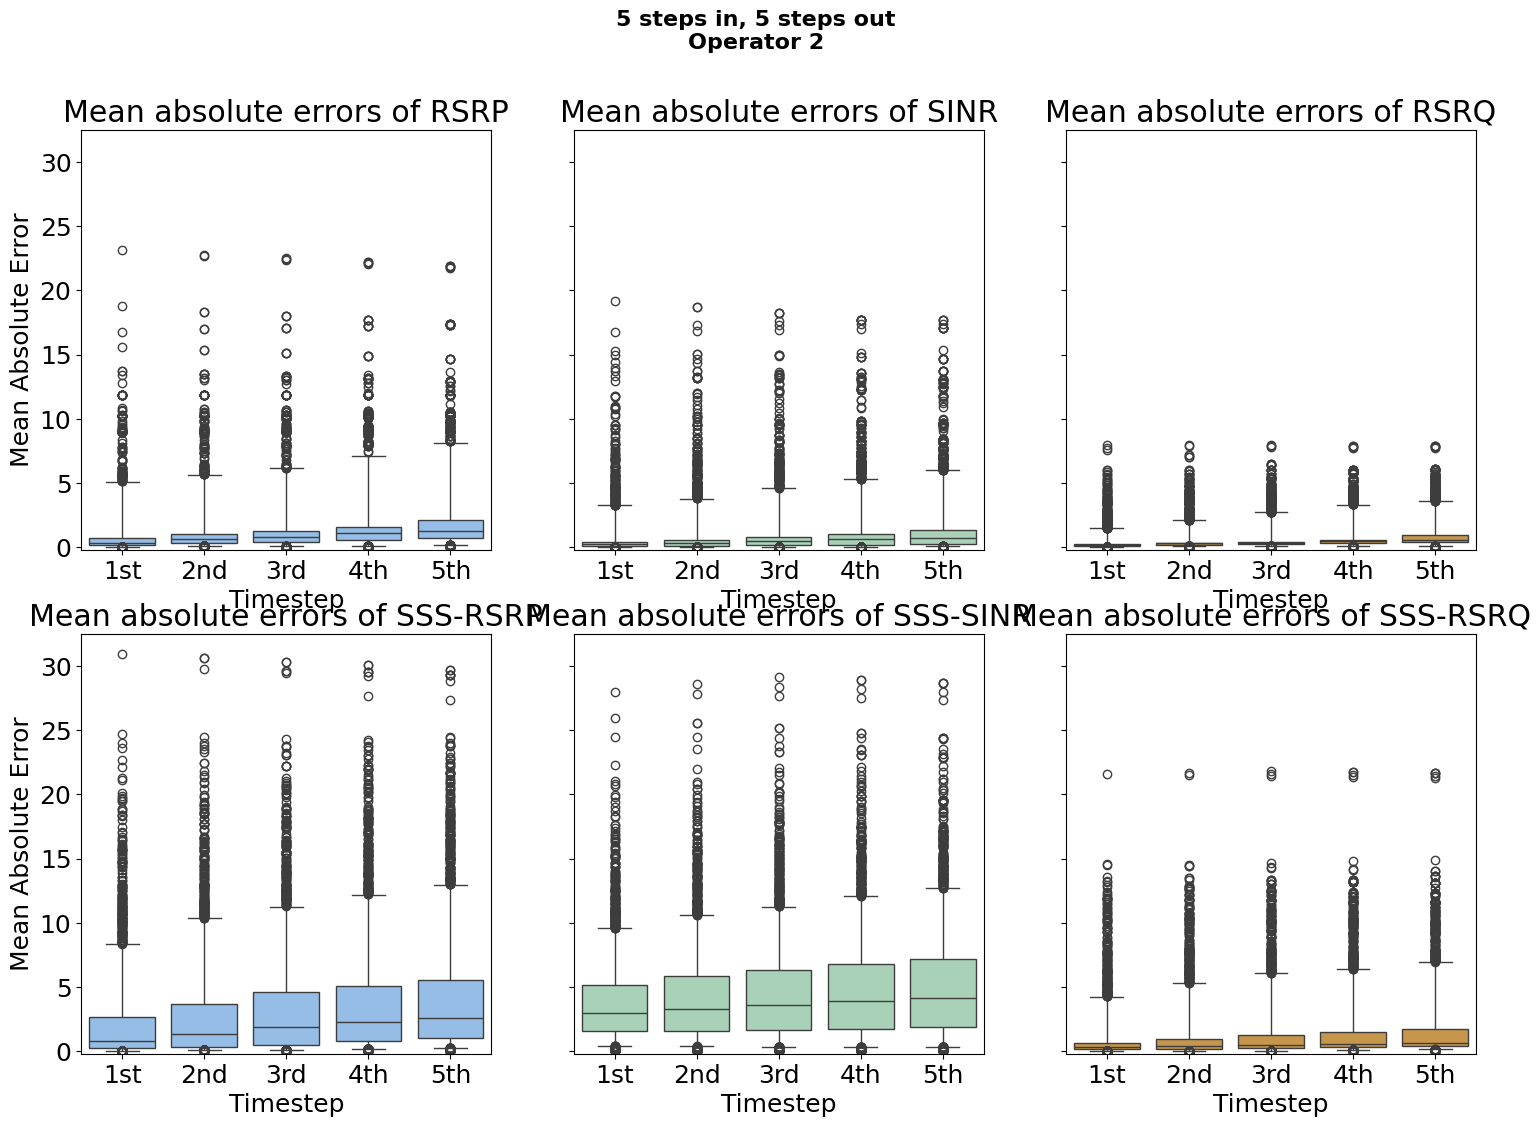

In [50]:
n_steps_in = 5
n_steps_out = 5

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_5_steps_mae.pdf')

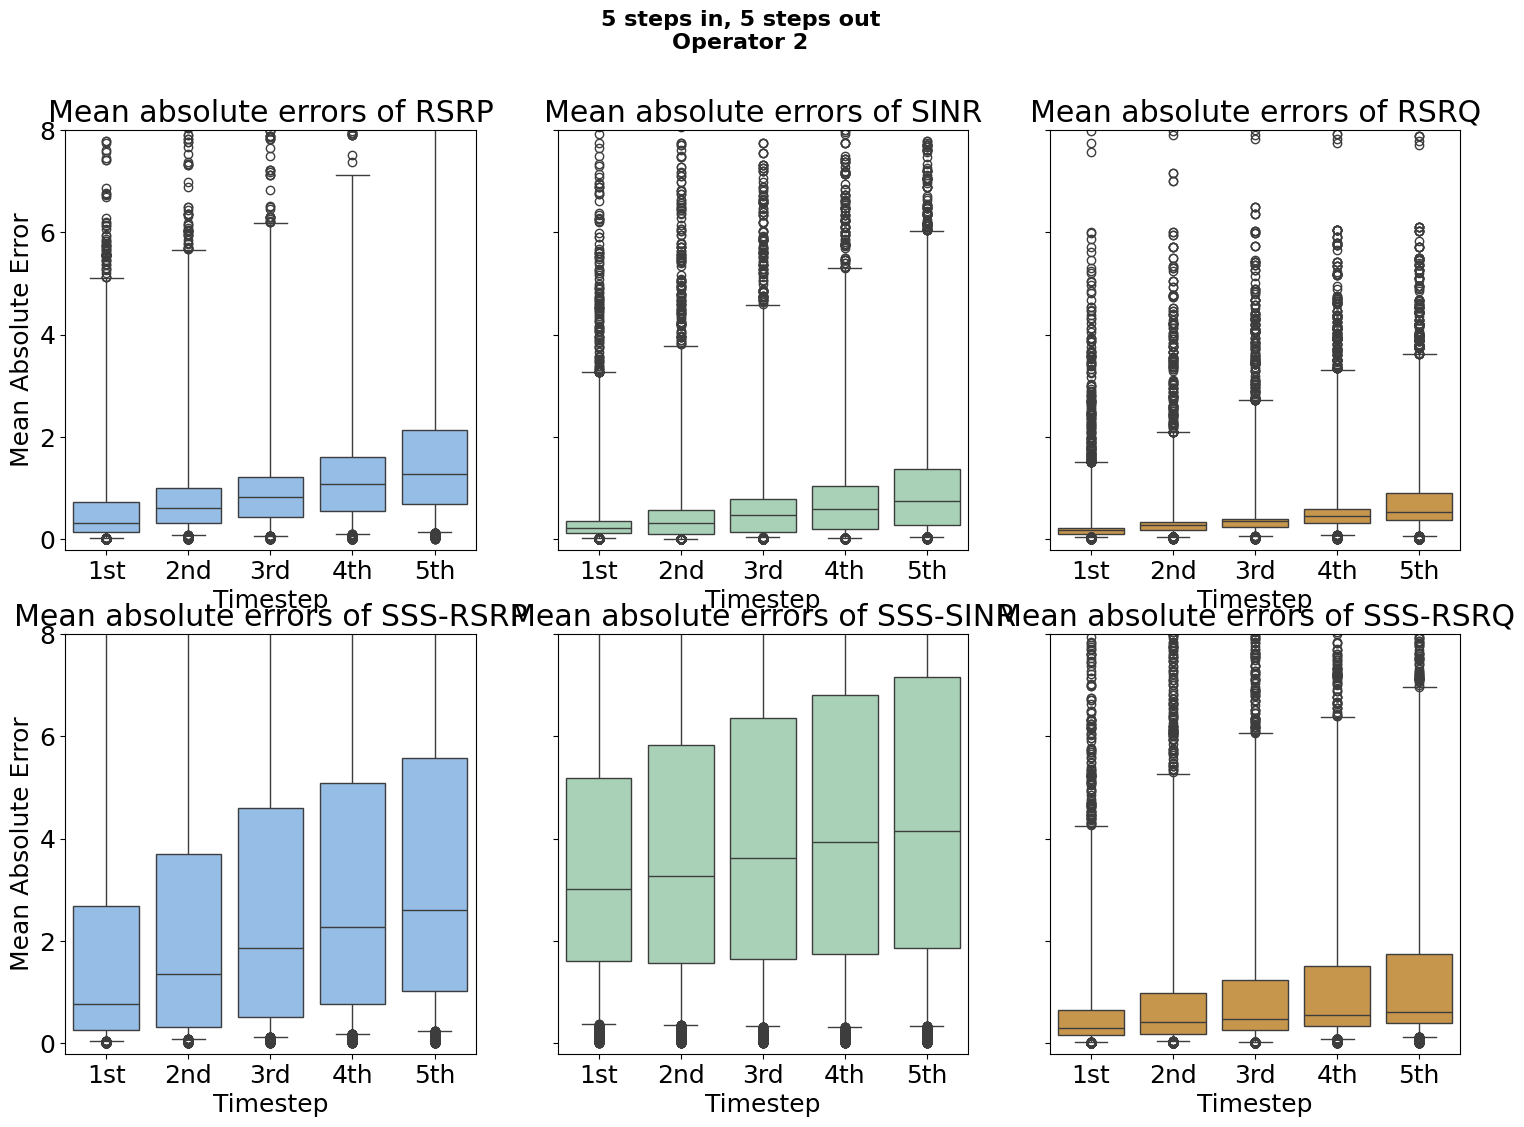

In [51]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator, y_lim=8)
fig.savefig(r'../latex/plots/lstm/op2_box_5_steps_mae_zoom.pdf')

In [52]:
mae_each_step

,1st,2nd,3rd,4th,5th
RSRP,1.109,1.391,1.626,1.863,2.092
SINR,0.674,0.863,1.064,1.263,1.457
RSRQ,0.369,0.525,0.658,0.787,0.897
SSS-RSRP,2.133,2.771,3.290,3.705,4.072
SSS-SINR,3.784,4.156,4.489,4.786,5.033
SSS-RSRQ,0.876,1.119,1.314,1.497,1.636


## 10 Steps Prediction

Different steps back

### 1 step back

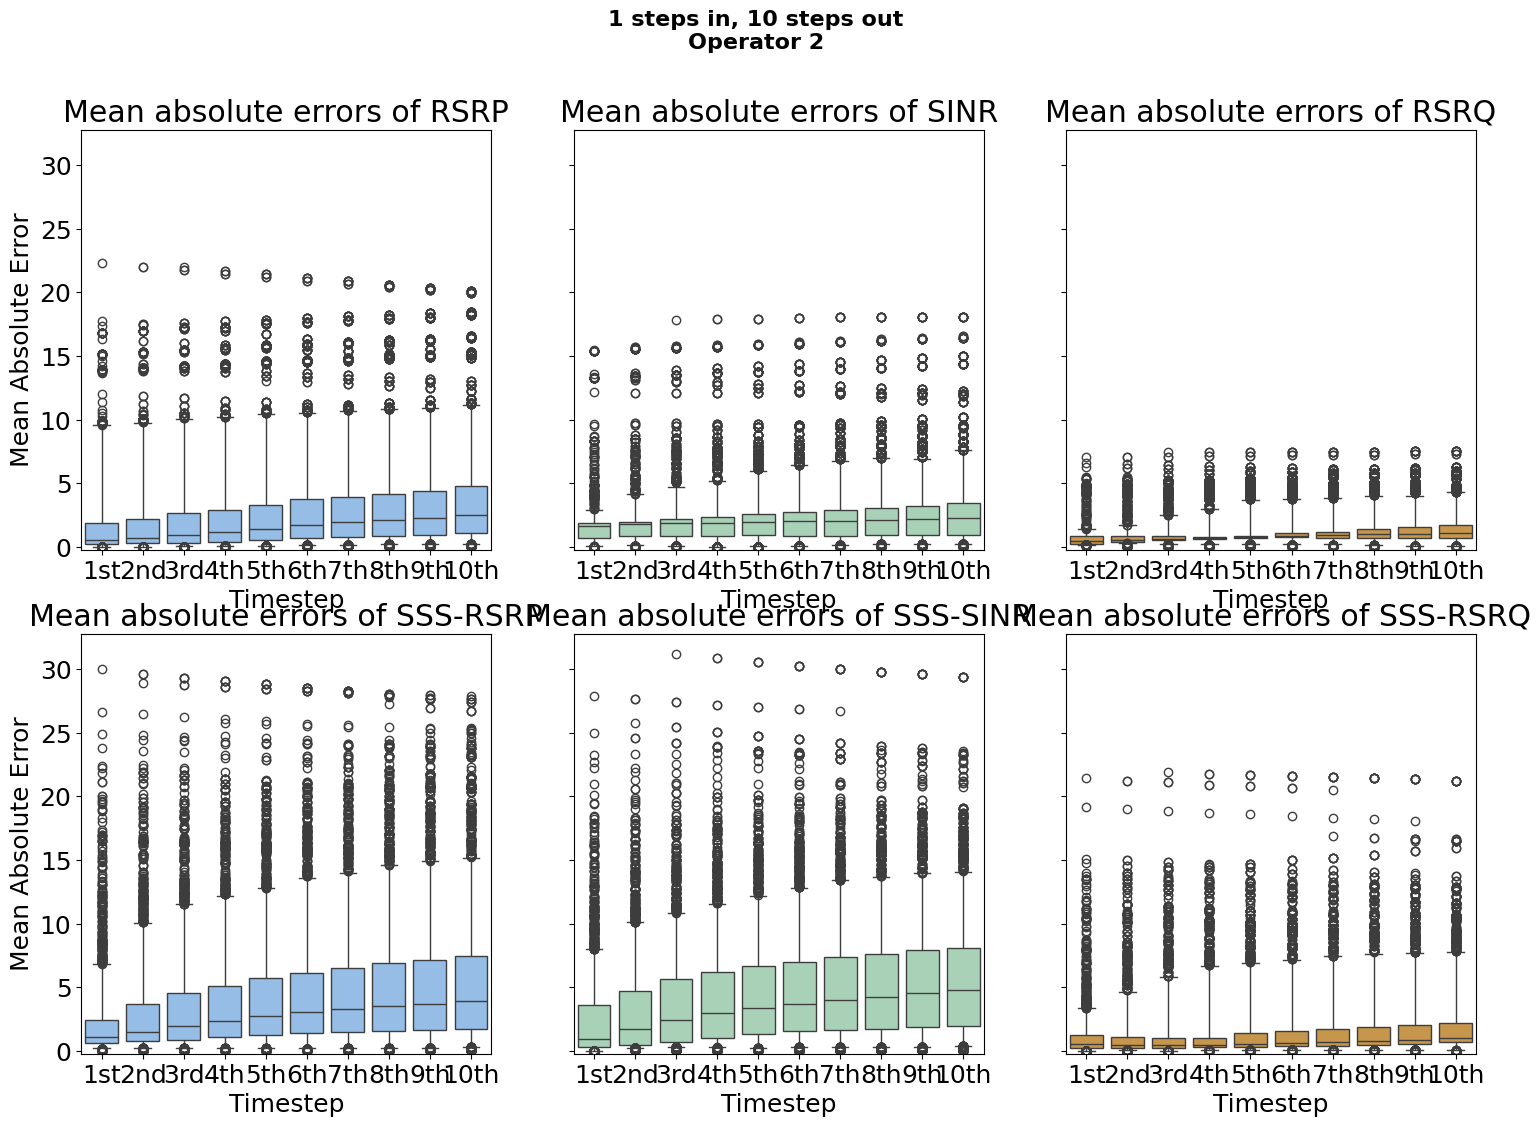

In [53]:
n_steps_in = 1
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_1_in_10_out_mae.pdf')

In [54]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.867,2.081,2.300,2.525,2.753,2.974,3.169,3.360,3.538,3.711
SINR,1.593,1.739,1.896,2.008,2.153,2.266,2.374,2.500,2.632,2.744
RSRQ,0.644,0.782,0.889,0.981,1.083,1.181,1.244,1.319,1.385,1.443
SSS-RSRP,2.111,2.859,3.411,3.824,4.184,4.503,4.748,4.973,5.145,5.320
SSS-SINR,2.368,3.132,3.701,4.140,4.493,4.796,5.037,5.264,5.456,5.623
SSS-RSRQ,1.000,1.146,1.281,1.400,1.517,1.646,1.758,1.860,1.962,2.060


### 2 steps back

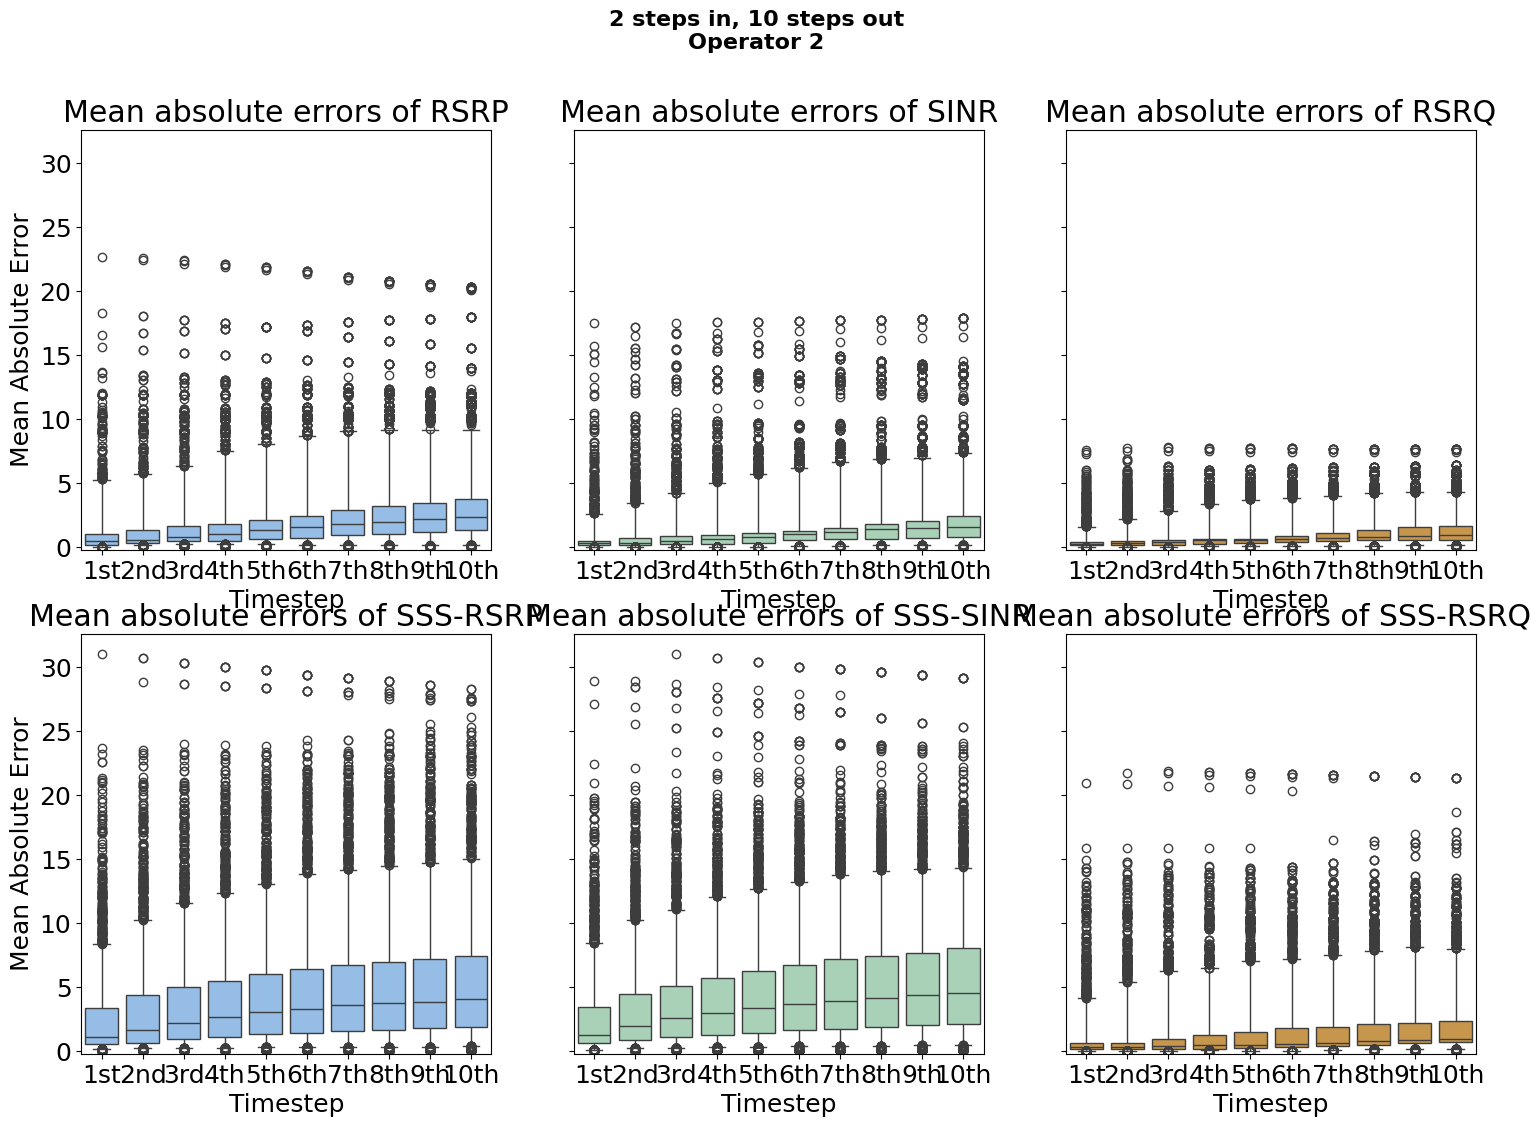

In [55]:
n_steps_in = 2
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_2_in_10_out_mae.pdf')

In [56]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.222,1.467,1.708,1.941,2.147,2.357,2.586,2.774,2.945,3.112
SINR,0.596,0.786,0.984,1.191,1.376,1.583,1.784,1.952,2.103,2.247
RSRQ,0.423,0.542,0.663,0.791,0.900,0.994,1.102,1.189,1.270,1.341
SSS-RSRP,2.493,3.115,3.597,3.993,4.345,4.627,4.855,5.044,5.224,5.382
SSS-SINR,2.561,3.233,3.747,4.157,4.498,4.793,5.013,5.233,5.419,5.593
SSS-RSRQ,0.877,1.057,1.220,1.371,1.518,1.657,1.779,1.893,1.996,2.092


### 3 steps back

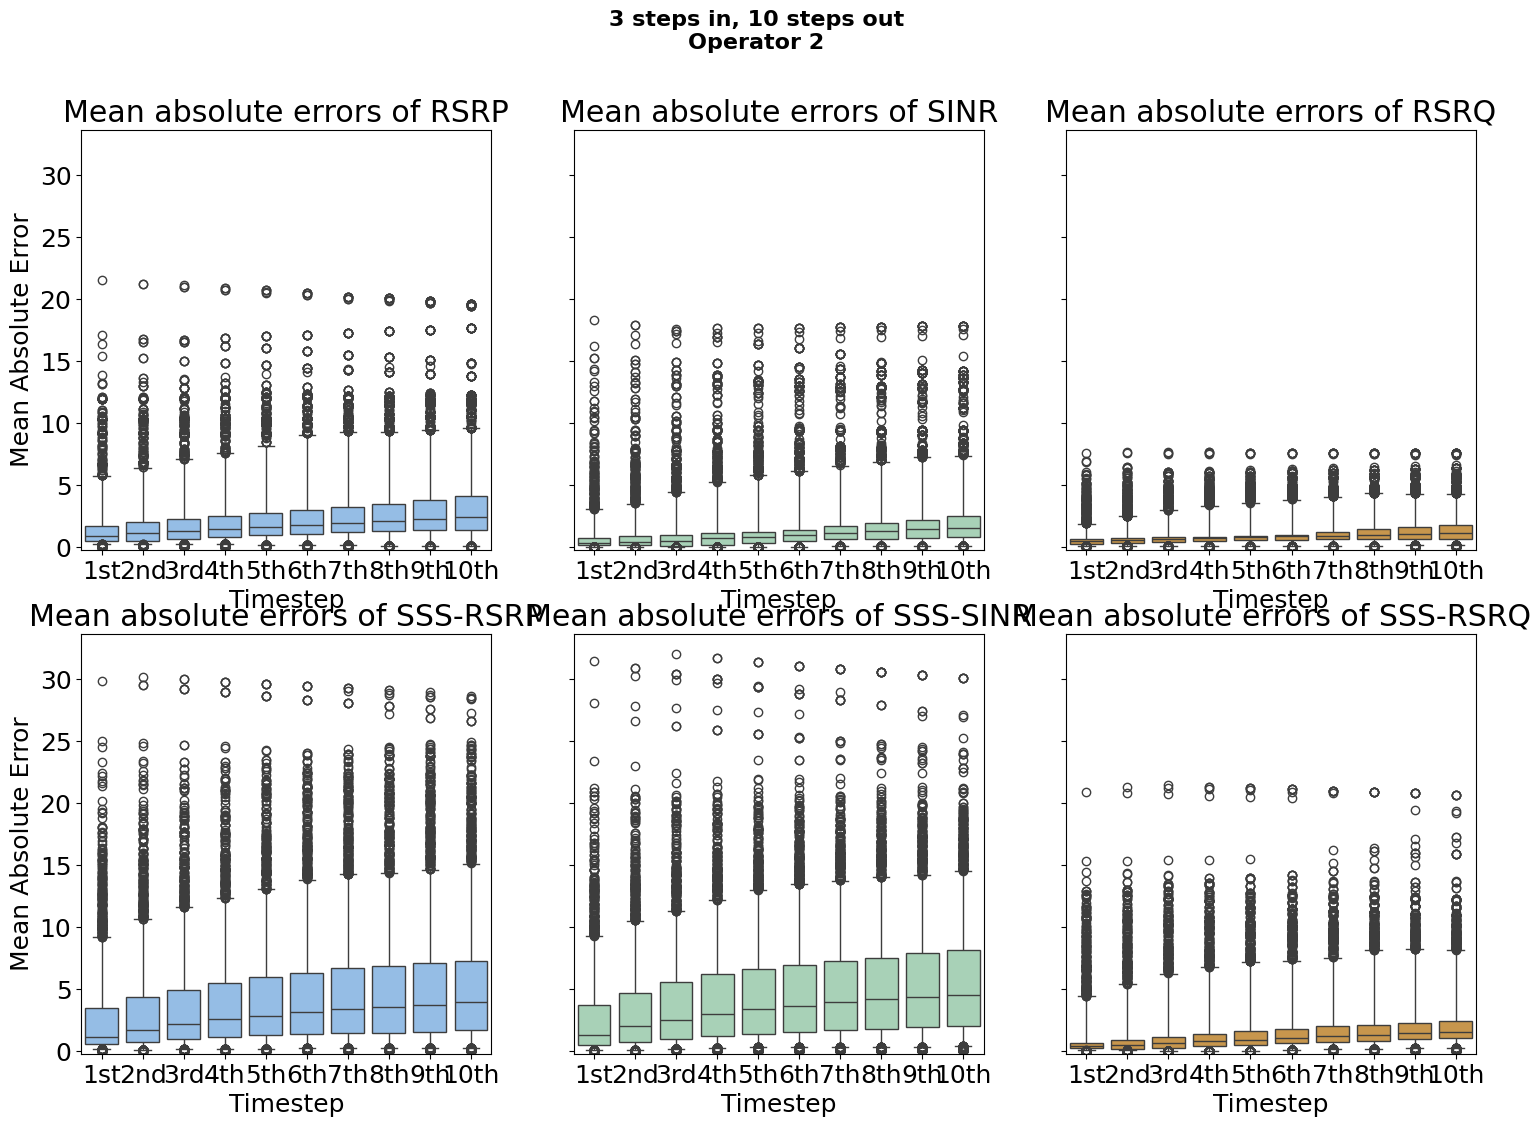

In [57]:
n_steps_in = 3
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_3_in_10_out_mae.pdf')

In [58]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.626,1.870,2.079,2.290,2.459,2.636,2.840,2.983,3.143,3.303
SINR,0.722,0.899,1.084,1.274,1.463,1.655,1.836,1.988,2.143,2.287
RSRQ,0.613,0.734,0.859,0.961,1.067,1.154,1.235,1.313,1.395,1.456
SSS-RSRP,2.605,3.171,3.623,4.001,4.335,4.599,4.817,4.999,5.162,5.315
SSS-SINR,2.692,3.332,3.835,4.242,4.579,4.845,5.062,5.268,5.449,5.610
SSS-RSRQ,0.987,1.190,1.380,1.555,1.713,1.864,1.997,2.111,2.225,2.323


### 5 steps back

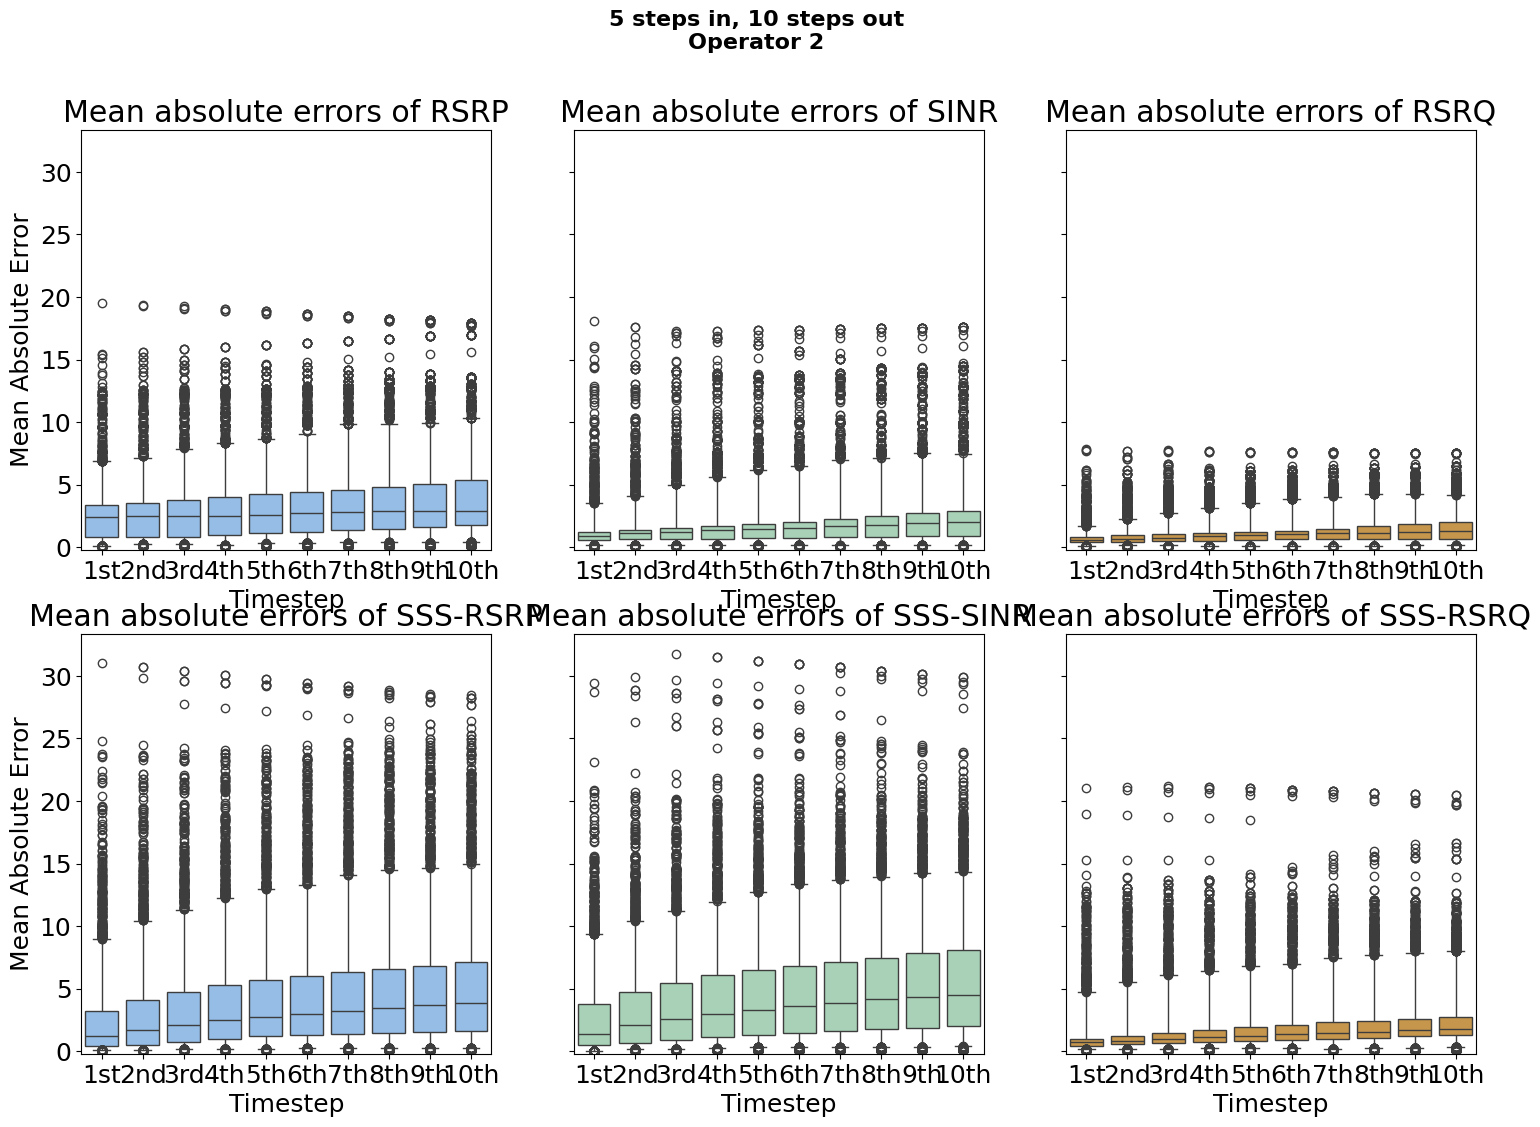

In [59]:
n_steps_in = 5
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_5_in_10_out_mae.pdf')

In [60]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,2.588,2.736,2.887,3.026,3.176,3.320,3.450,3.600,3.707,3.855
SINR,1.165,1.365,1.550,1.736,1.906,2.062,2.210,2.363,2.500,2.622
RSRQ,0.699,0.832,0.944,1.054,1.156,1.252,1.339,1.415,1.488,1.551
SSS-RSRP,2.481,3.034,3.482,3.855,4.178,4.452,4.672,4.856,5.020,5.186
SSS-SINR,2.708,3.325,3.800,4.185,4.502,4.775,5.003,5.214,5.402,5.580
SSS-RSRQ,1.215,1.449,1.634,1.795,1.938,2.076,2.192,2.303,2.402,2.511


### 10 steps back

In [61]:
n_steps_in = 10
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.01538,0.01282,2.65,2.42
1,"RSRP, SSS_RSRP -> RSRP",0.01599,0.01574,2.71,2.56
2,SINR -> SINR,0.00704,0.00122,1.81,1.57
3,"SINR, SSS_SINR -> SINR",0.00644,0.00105,1.78,1.37
4,RSRQ -> RSRQ,0.01148,0.01068,1.64,1.63
5,"RSRQ, SSS_RSRQ -> RSRQ",0.01162,0.00732,1.30,1.24
6,SSS_RSRP -> SSS_RSRP,0.01259,0.01115,4.60,4.03
7,"RSRP, SSS_RSRP -> SSS_RSRP",0.01115,0.01324,4.67,3.78
8,SSS_SINR -> SSS_SINR,0.01449,0.01025,4.78,3.81
9,"SINR, SSS_SINR -> SSS_SINR",0.01424,0.01086,4.47,3.73


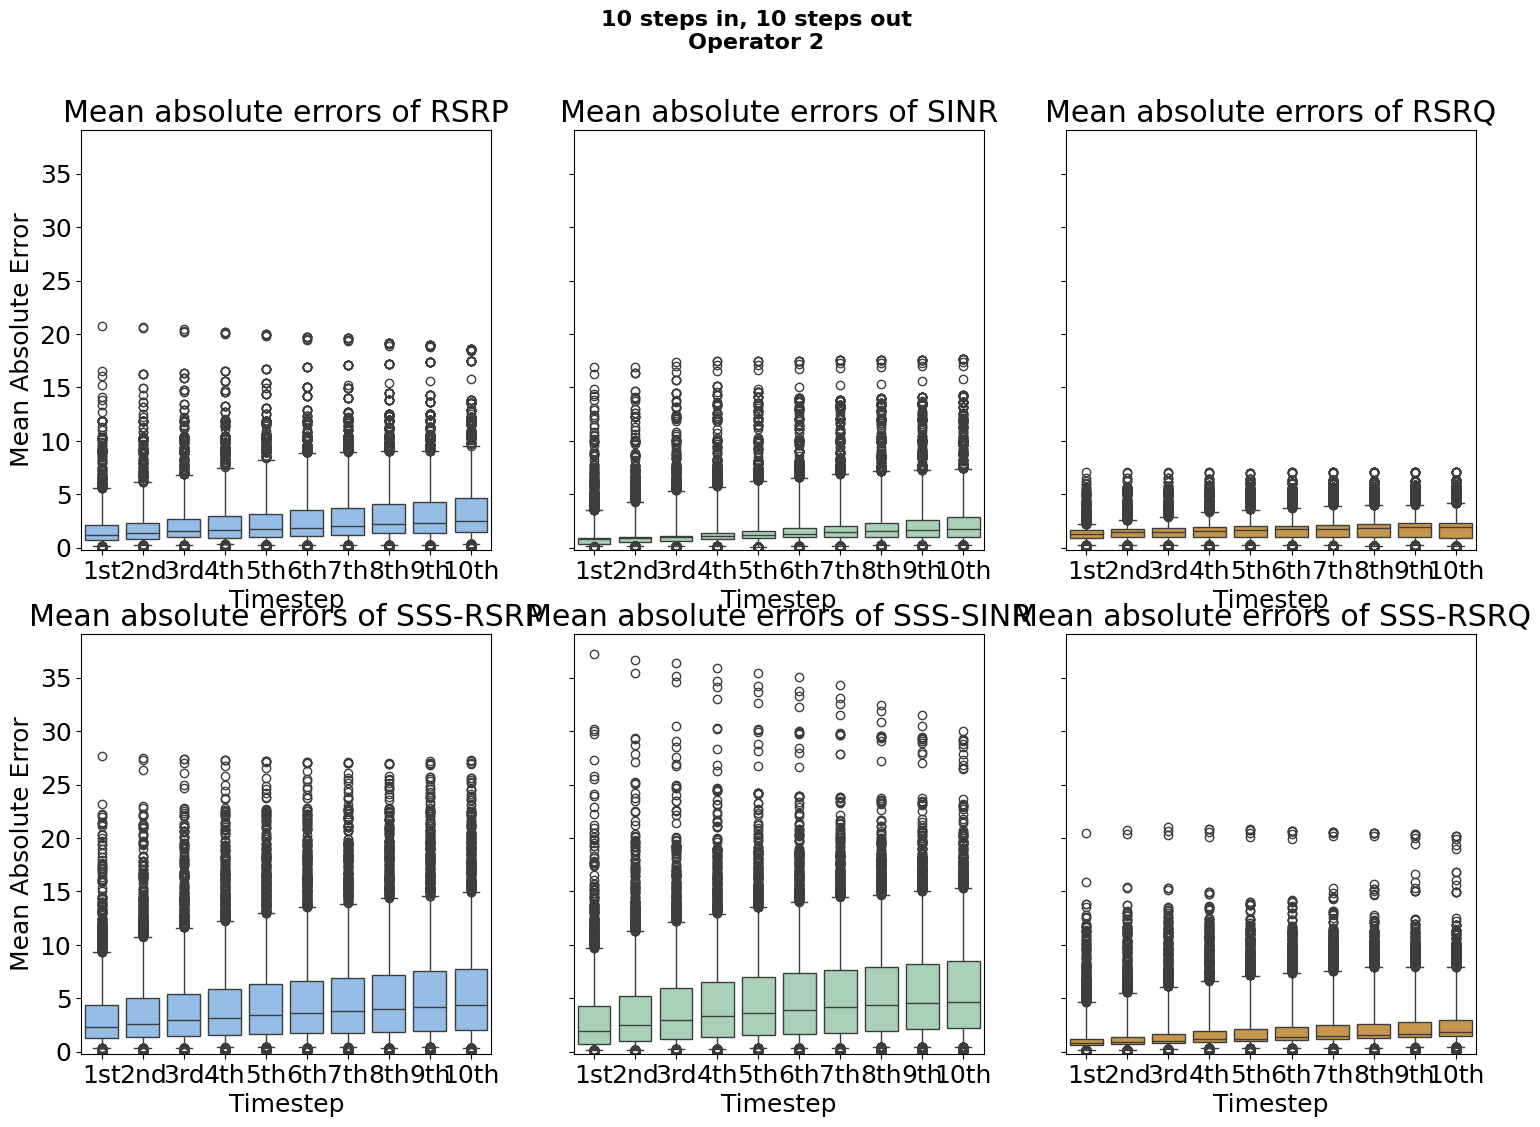

In [62]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_10_in_10_out_mae.pdf')

In [63]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.832,2.021,2.250,2.423,2.580,2.782,2.896,3.100,3.235,3.411
SINR,1.023,1.214,1.414,1.611,1.766,1.940,2.083,2.231,2.358,2.473
RSRQ,1.299,1.410,1.491,1.580,1.640,1.692,1.754,1.799,1.848,1.880
SSS-RSRP,3.284,3.689,4.046,4.349,4.627,4.858,5.038,5.227,5.392,5.533
SSS-SINR,3.112,3.691,4.155,4.525,4.838,5.096,5.310,5.526,5.705,5.861
SSS-RSRQ,1.294,1.534,1.741,1.924,2.043,2.190,2.312,2.400,2.517,2.620


### 20 steps back

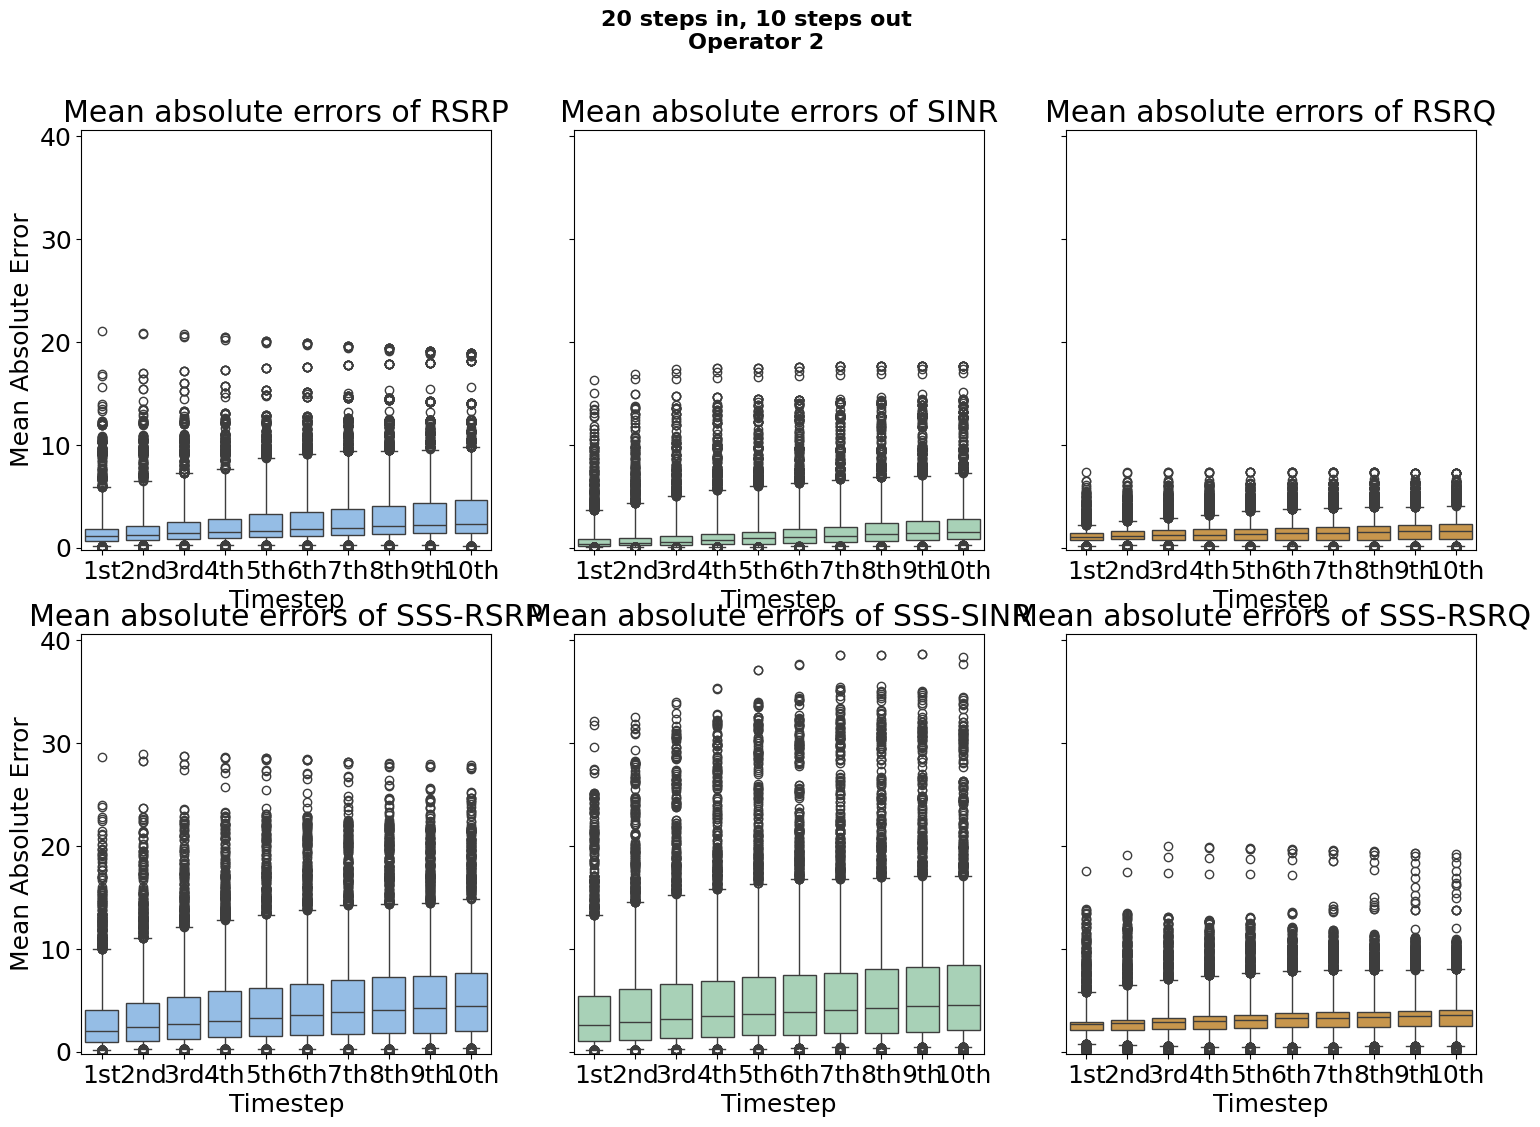

In [64]:
n_steps_in = 20
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_20_in_10_out_mae.pdf')

In [65]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.778,2.010,2.224,2.412,2.606,2.768,2.945,3.103,3.264,3.412
SINR,0.879,1.047,1.208,1.393,1.562,1.734,1.891,2.037,2.187,2.325
RSRQ,1.147,1.239,1.324,1.396,1.463,1.527,1.586,1.645,1.709,1.764
SSS-RSRP,3.114,3.595,3.987,4.313,4.574,4.808,5.031,5.218,5.364,5.532
SSS-SINR,4.029,4.473,4.837,5.110,5.368,5.559,5.744,5.894,6.028,6.143
SSS-RSRQ,2.799,2.941,3.101,3.198,3.292,3.382,3.435,3.466,3.557,3.596


### 30 steps back

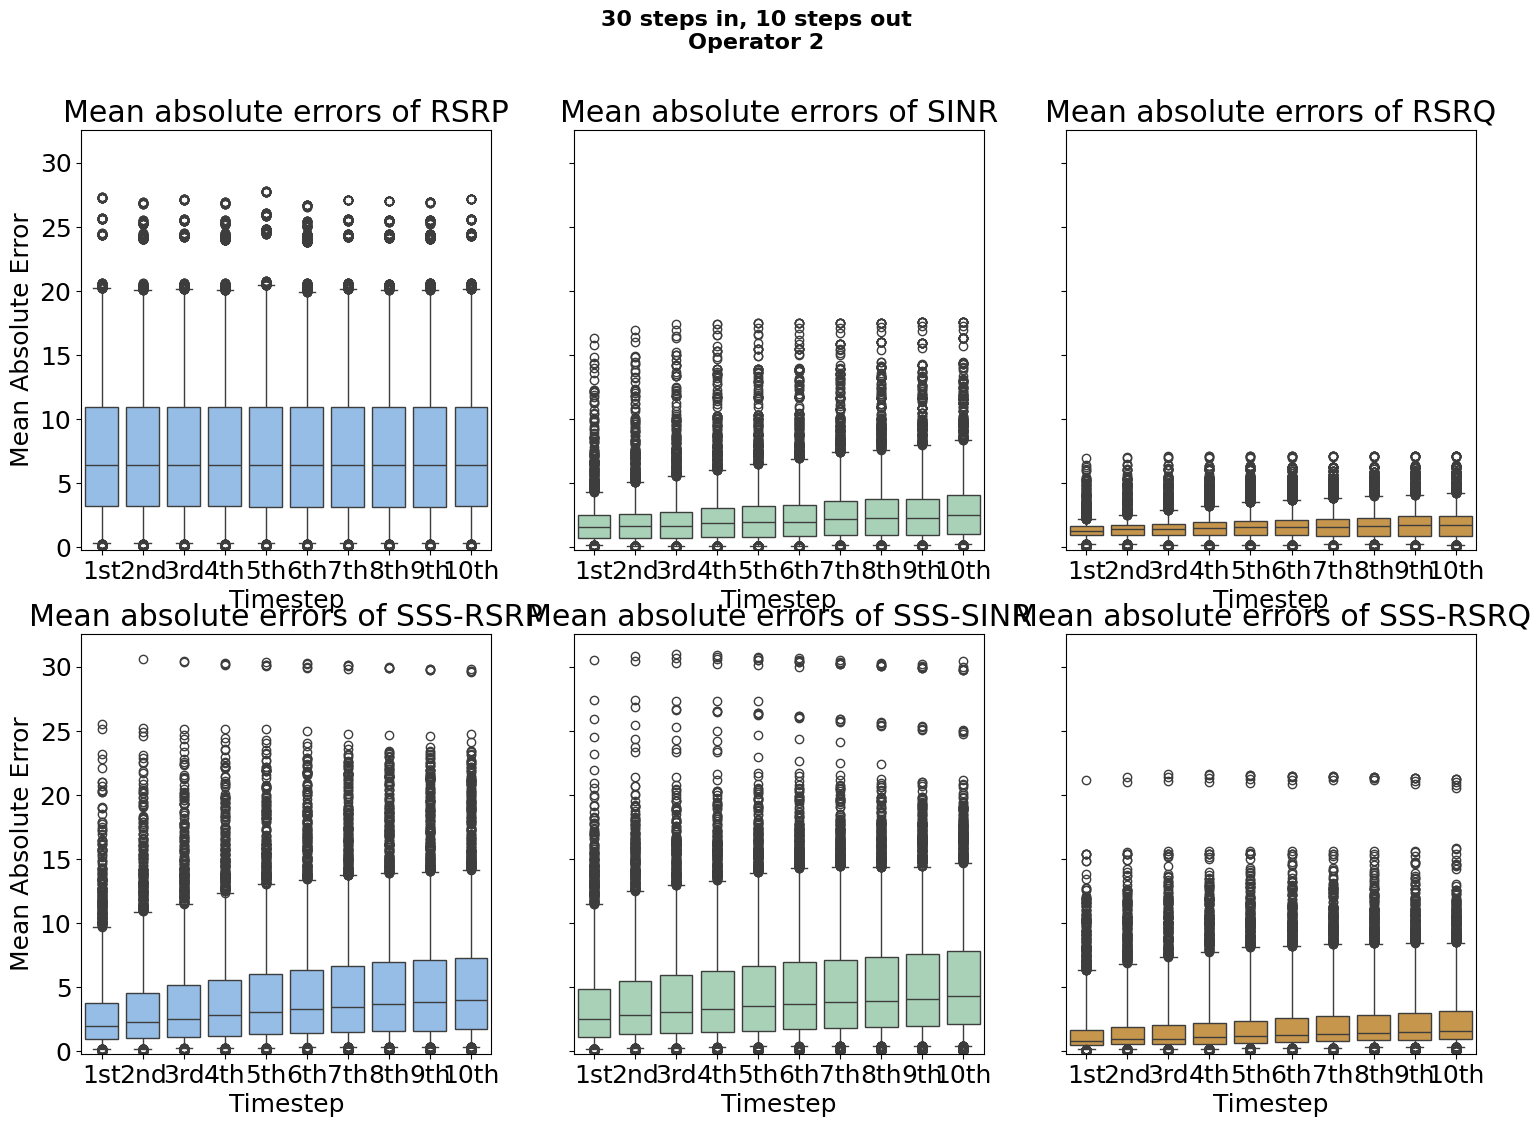

In [66]:
n_steps_in = 30
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_30_in_10_out_mae.pdf')

In [67]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,7.736,7.716,7.727,7.715,7.756,7.704,7.725,7.722,7.718,7.731
SINR,1.856,1.972,2.076,2.275,2.376,2.456,2.664,2.791,2.832,3.002
RSRQ,1.285,1.383,1.457,1.536,1.596,1.646,1.680,1.750,1.814,1.857
SSS-RSRP,2.981,3.435,3.797,4.097,4.348,4.568,4.752,4.913,5.062,5.206
SSS-SINR,3.635,4.054,4.326,4.559,4.786,4.968,5.114,5.240,5.372,5.505
SSS-RSRQ,1.565,1.778,1.884,2.012,2.148,2.270,2.341,2.427,2.497,2.562


### 40 steps back

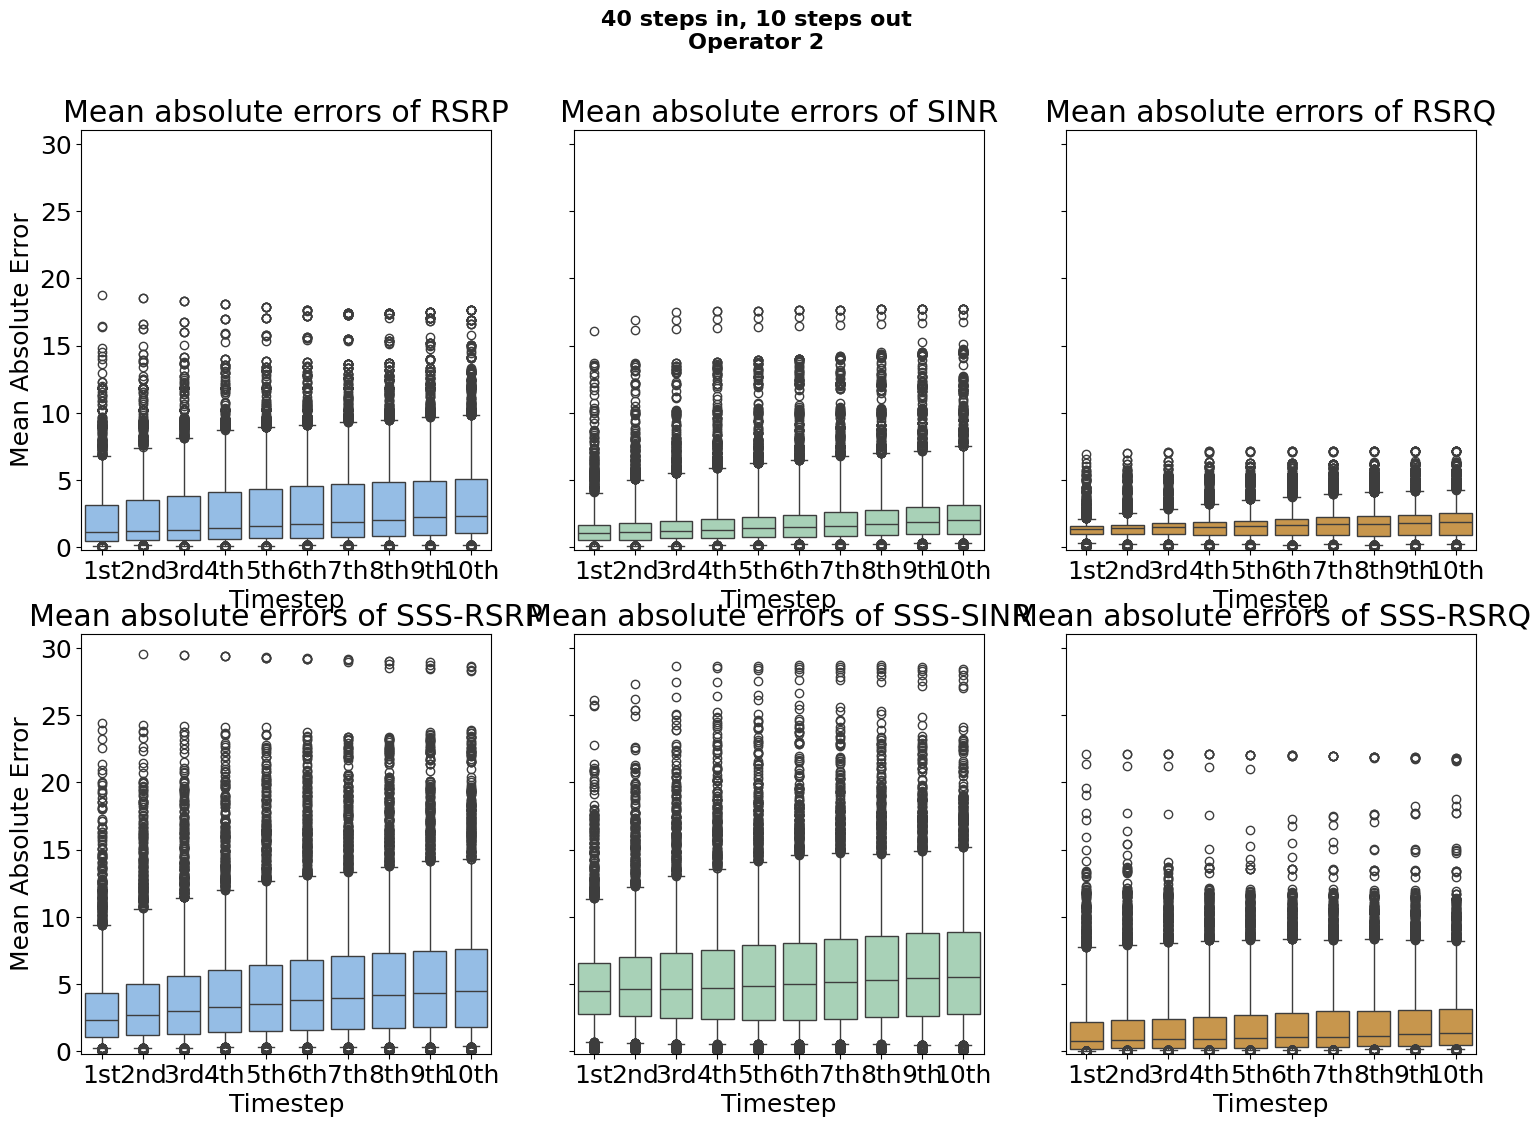

In [68]:
n_steps_in = 40
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

fig, mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/lstm/op2_box_40_in_10_out_mae.pdf')

In [69]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,2.092,2.249,2.394,2.566,2.723,2.879,3.025,3.165,3.324,3.467
SINR,1.323,1.476,1.645,1.808,1.957,2.103,2.245,2.384,2.518,2.655
RSRQ,1.308,1.375,1.453,1.516,1.574,1.649,1.718,1.752,1.811,1.871
SSS-RSRP,3.219,3.649,4.002,4.305,4.547,4.772,4.941,5.101,5.236,5.378
SSS-SINR,5.035,5.280,5.416,5.578,5.722,5.822,5.945,6.056,6.165,6.264
SSS-RSRQ,1.779,1.883,1.961,2.034,2.108,2.168,2.221,2.274,2.320,2.361
